### #import thư viện cần thiết

In [56]:
import re# thư viện để python làm việc với biểu thức chính quy
import csv# thư viện để xử lí file .csv
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer# thư viện để tokenize
from pyvi import ViUtils 

### # ghi dữ liệu sang một file mới
### # loại bỏ stopword, kí tự, viết hoa
### # kiểm tra xem có comment hoặc label nào bị trống không

In [ ]:
# đọc dữ liệu từ file gốc và sau đó loại bỏ stopwords và lưu lại vào file ra
input_file_path = 'output.csv'  # File CSV cần xử lý
output_file_path = 'data.csv'       # File CSV đầu ra
# Hàm đọc danh sách stopwords từ file
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())  # Đọc từng dòng và lưu vào set
    return stopwords
# Lấy danh sách stopwords từ file
stopwords = load_stopwords('vietnamese_stopwords.txt')
# Hàm làm sạch văn bản
def clean_text(text):
    # Chuyển tất cả chữ về dạng viết thường
    text = text.lower()
    # Loại bỏ emoji, ký tự đặc biệt, chỉ giữ lại chữ cái và khoảng trắng
    text = re.sub(r'[^\w\sáàạảãạăắằặẳẵâấầậẩẫéèẹẻẽêếềệểễíìịỉĩóòọỏõôốồộổỗơớờợởỡúùụủũưứừựửữýỳýỵỷỹđ]', '', text)
    # Loại bỏ stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text
# Đọc dữ liệu từ file CSV
try:
    with open(input_file_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        data1 = list(reader)  # Đọc toàn bộ dữ liệu từ file CSV
except FileNotFoundError:
    print(f"Không tìm thấy file: {input_file_path}")
    exit()
except csv.Error:
    print(f"Lỗi khi đọc file CSV: {input_file_path}")
    exit()
# Lọc và xử lý các mục comment, kiểm tra label và chỉ ghi lại những phần hợp lệ
processed_data1 = []
empty_rows = []  # Danh sách lưu dòng có dữ liệu trống
for index, item in enumerate(data1):
    comment = item.get('Comment', '').strip()
    label = item.get('Label', '').strip()
    # Kiểm tra dòng nào có dữ liệu bị trống
    if not comment or not label:
        empty_rows.append(index + 1)  # Lưu chỉ mục dòng (bắt đầu từ 1)
        continue
    # Xử lý comment
    cleaned_comment = clean_text(comment)
    processed_data1.append({'Comment': cleaned_comment, 'Label': label})
# Báo các dòng có dữ liệu bị trống
if empty_rows:
    print(f"Các dòng sau có dữ liệu trống ở cột 'Comment' hoặc 'Label': {empty_rows}")
# Ghi lại dữ liệu đã xử lý vào file CSV mới
try:
    with open(output_file_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=['Comment', 'Label'])
        writer.writeheader()  # Ghi tiêu đề cột
        writer.writerows(processed_data1)  # Ghi dữ liệu
    print(f"Dữ liệu đã được ghi vào {output_file_path}")
except IOError:
    print(f"Không thể ghi dữ liệu vào file {output_file_path}")

In [ ]:
data = pd.read_csv('data.csv')
data.head()

### #Lọc comment và label

In [ ]:
st_data =pd.DataFrame({'Comment': data['Comment'],'Label': data['Label']})
st_data = st_data.dropna()
st_data = st_data.reset_index(drop=True)
st_data.head()

### # Tạo một bản sao không có dấu, tokenization & lưu tạm

In [64]:
input_comment = st_data['Comment'].values
input_label = st_data['Label'].values
label_dictionary ={'positive':1,'negative':0}
input_pre =[]
label_accent =[]
for idx, dt in enumerate(input_comment):
    input_text_pre =list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))# phần này là phần đã loại bỏ dấu
    input_text_pre_accent =ViTokenizer.tokenize(input_text_pre)# tokenization cho văn bản có dấu
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)# tokenization cho văn bản đã loại bỏ dấu
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_accent.append(input_label[idx])
    label_accent.append(input_label[idx])

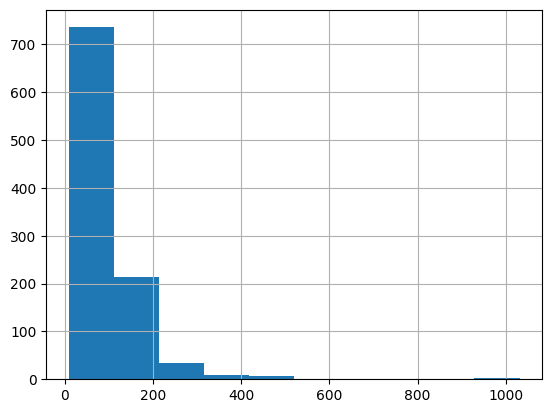

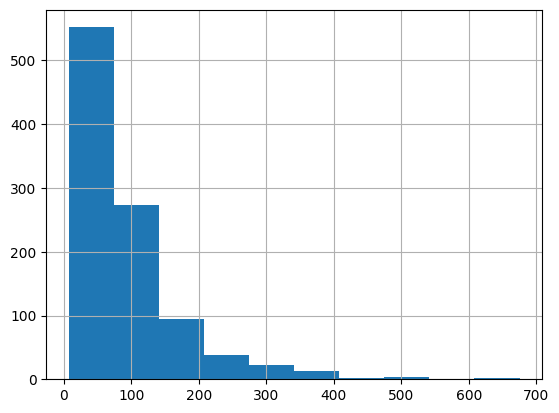

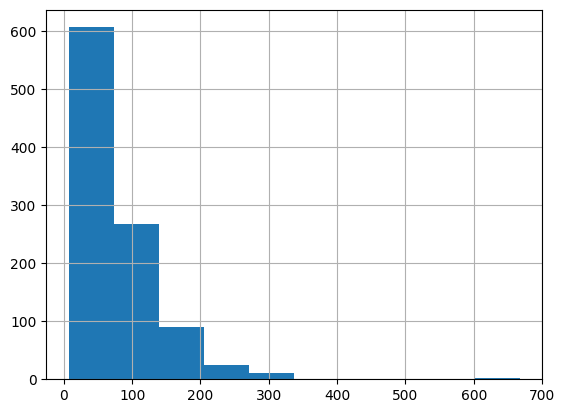

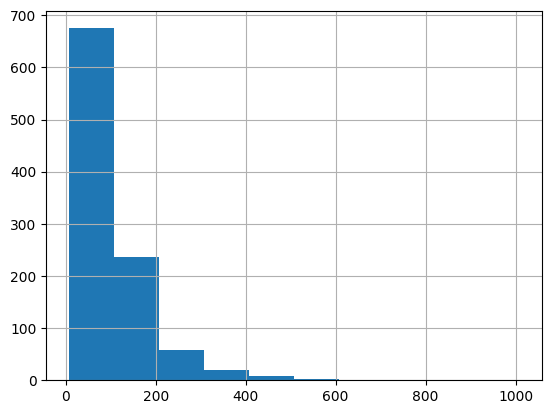

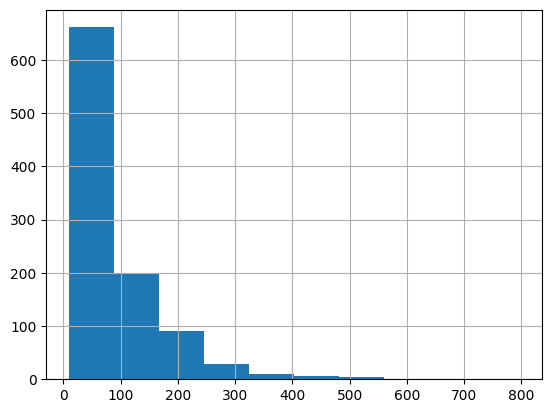

In [65]:
# lấy thông số và kiểm tra tần xuất
seq_len =[len(i.split())for i in input_pre[0:1000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[1000:2000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[2000:3000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[3000:4000]]
pd.Series(seq_len).hist(bins =10)
plt.show()
seq_len =[len(i.split())for i in input_pre[4000:5000]]
pd.Series(seq_len).hist(bins =10)
plt.show()

In [ ]:
file_path = 'data.csv' 
df = pd.read_csv(file_path)
# Kiểm tra xem cột 'Comment' có tồn tại trong file không
if 'Comment' in df.columns:
    # Đếm số từ trong mỗi bình luận
    df['word_count'] = df['Comment'].apply(lambda x: len(str(x).split()))  
    # Tìm bình luận có số từ nhiều nhất
    max_word_count_row = df.loc[df['word_count'].idxmax()]
    print(f"Bình luận có số từ nhiều nhất là ở dòng {max_word_count_row.name} với {max_word_count_row['word_count']} từ.")
    print(f"Đoạn bình luận: {max_word_count_row['Comment']}")
else:
    print("Không tìm thấy cột 'Comment' trong file CSV.")


In [66]:
# chuyển đổi nhãn thành số và dạng one hot encoding
label_idx =[label_dictionary[i]for i in label_accent]
label_tf =tf.keras.utils.to_categorical(label_idx,num_classes=2)
# Tạo một tokenizer cho việc tách từ trong văn bản
tokenizer_data=Tokenizer(oov_token='<OOV>', split=' ')
# huấn luyện
tokenizer_data.fit_on_texts(input_pre)
# chuyển văn bản thành các chuỗi số
tokenizer_data_text=tokenizer_data.texts_to_sequences(input_pre)
# Padding các chuỗi số, đảm bảo mỗi chuỗi có độ dài cố định (512 từ)
vec_data = pad_sequences(tokenizer_data_text,padding='post',maxlen=512)
# Lưu tokenizer đã huấn luyện vào file pickle để sử dụng sau này
pickle.dump(tokenizer_data,open("tokenizer_data.pkl", "wb"))
print("comment data.shape ",vec_data.shape)
data_voca_size =len(tokenizer_data.word_index)+1
print("data_voca_size: ",data_voca_size)
#chia tệp dữ liệu thành bộ train và bộ validation 8-2
x_train, x_val,y_train,y_val= train_test_split(vec_data, label_tf,test_size=0.2,random_state=42)
#chia tệp dữ liệu thành bộ train và bộ test 9-1
x_train, x_test,y_train,y_test= train_test_split(vec_data, label_tf,test_size=0.1,random_state=42)
print("training sample: ",len(x_train))
print("validation sample: ",len(x_val))
print("test sample: ",len(x_test))

KeyError: 'label'

### # Build CNN +Bidirectional KSTM model for vietnamese language

In [ ]:

def generate_model():
    dropout_threshold = 0.4
    input_dim = data_voca_size  # Vocabulary size
    output_dim = 64  # Increased embedding dimensions
    input_length = 512
    initializer = tf.keras.initializers.GlorotNormal()
    
    # Input layer
    input_layer = Input(shape=(input_length,))
    
    # Embedding layer
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, 
                         embeddings_initializer="GlorotNormal")(input_layer)
    
    # CNN block
    cnn_feature = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    cnn_feature = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)
    
    # Bidirectional LSTM/GRU block
    rnn_feature = Bidirectional(LSTM(units=64, dropout=dropout_threshold, return_sequences=True,
                                      kernel_initializer=initializer), merge_mode='concat')(feature)
    rnn_feature = MaxPooling1D()(rnn_feature)
    rnn_feature = Bidirectional(GRU(units=64, dropout=dropout_threshold, return_sequences=True,
                                     kernel_initializer=initializer), merge_mode='concat')(rnn_feature)
    rnn_feature = MaxPooling1D()(rnn_feature)
    rnn_feature = LayerNormalization()(rnn_feature)
    
    # Combine features
    combined_feature = Concatenate()([cnn_feature, rnn_feature])
    combined_feature = GlobalMaxPooling1D()(combined_feature)
    combined_feature = LayerNormalization()(combined_feature)
    
    # Fully connected layers
    classifier = Dense(128, activation='relu')(combined_feature)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(64, activation='relu')(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(32, activation='relu')(classifier)
    classifier = Dropout(0.3)(classifier)
    classifier = Dense(2, activation='softmax')(classifier)  # Final output layer for 3 classes
    
    # Model
    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

# Compile and summarize the model
model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


### # Define model checkPoint & training

In [ ]:
callback_model =tf.keras.callbacks.ModelCheckpoint('model.keras',monitor='val_loss')
history =model.fit(x=x_train,y=y_train,validation_data=(x_val,y_val),epochs=10, batch_size=128,callbacks=[callback_model])

### #model load on test data

In [ ]:
model.load_weights("model.keras")
model.evaluate(x_test,y_test)

In [ ]:
def preprocess_input(raw_input, tokenizer):
    input_text_pre =list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre =" ".join(input_text_pre)
    input_text_pre_accent= ViTokenizer.tokenize(input_text_pre)
    print("text preprocessed: ",input_text_pre_accent)
    tokenizer_data_text=tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenizer_data_text,padding='post',maxlen =512)
    return vec_data
def inference_model(input_feature,model):
    output=model(input_feature).numpy()[0]
    result =output.argmax()
    conf =float(output.max())
    label_dictionary={'negative':0,'positive':1}
    label =list(label_dictionary.keys())
    return label[int(result)],conf
def prediction(raw_input, tokenizer,model):
    input_model=preprocess_input(raw_input,tokenizer_data)
    result,conf=inference_model(input_model,model)
    return result, conf
m_model= generate_model()
m_model=load_model('model.keras')
with open(r"tokenizer_data.pkl","rb")as input_file:
    my_tokenizer=pickle.load(input_file)
print(prediction("phim không hay",my_tokenizer,m_model))

In [13]:
#while(True):
 #   text=input()
   # if text =="end":
   #     break
   # else:
    #    print(prediction(text,my_tokenizer,m_model)[0]+"\n")